Using device: cuda


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


Training: 100%|██████████| 966/966 [10:16<00:00,  1.57it/s]


Train Loss: 0.6052, Train Accuracy: 78.08%


Evaluating: 100%|██████████| 123/123 [00:27<00:00,  4.54it/s]


Validation Accuracy: 85.04%


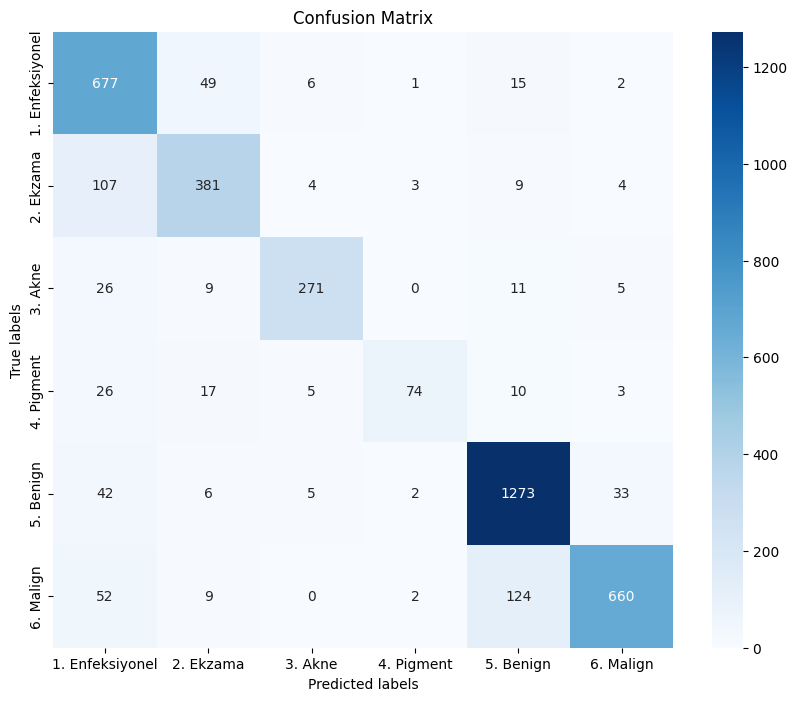

Epoch 2/10


Training: 100%|██████████| 966/966 [10:15<00:00,  1.57it/s]


Train Loss: 0.2745, Train Accuracy: 90.70%


Evaluating: 100%|██████████| 123/123 [00:26<00:00,  4.60it/s]


Validation Accuracy: 89.24%


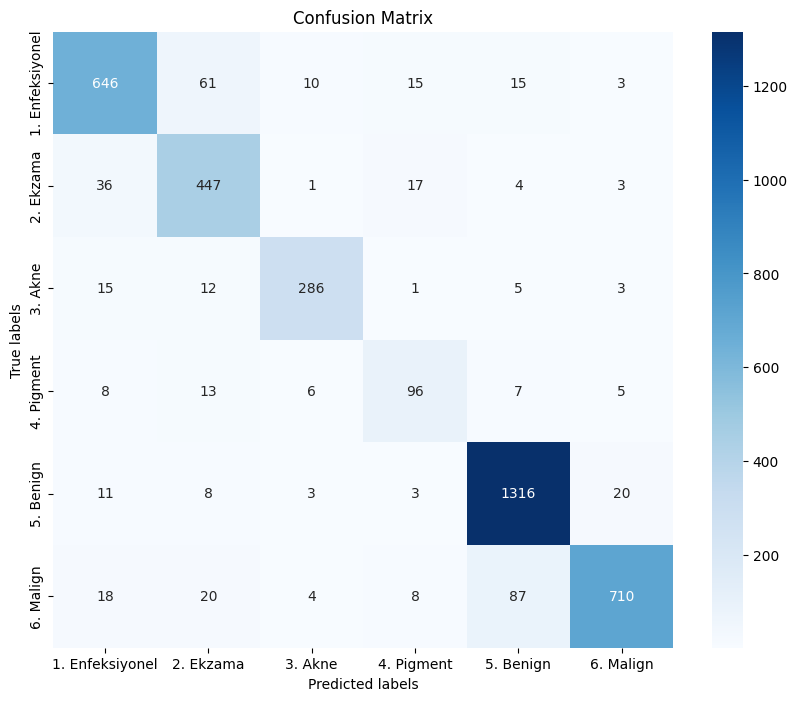

Epoch 3/10


Training: 100%|██████████| 966/966 [10:15<00:00,  1.57it/s]


Train Loss: 0.1338, Train Accuracy: 95.66%


Evaluating: 100%|██████████| 123/123 [00:26<00:00,  4.58it/s]


Validation Accuracy: 90.59%


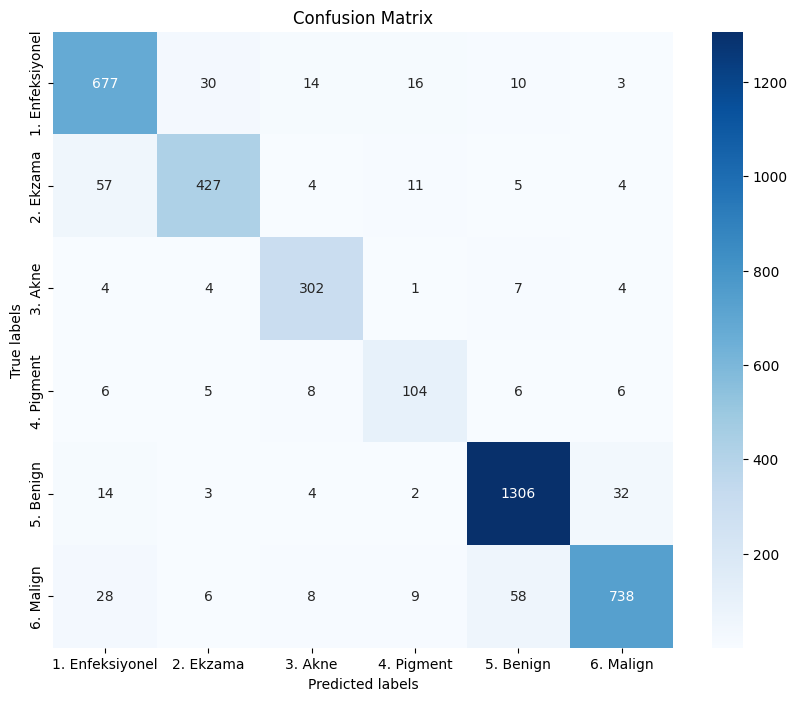

Epoch 4/10


Training: 100%|██████████| 966/966 [10:16<00:00,  1.57it/s]


Train Loss: 0.0855, Train Accuracy: 97.34%


Evaluating: 100%|██████████| 123/123 [00:26<00:00,  4.59it/s]


Validation Accuracy: 90.39%


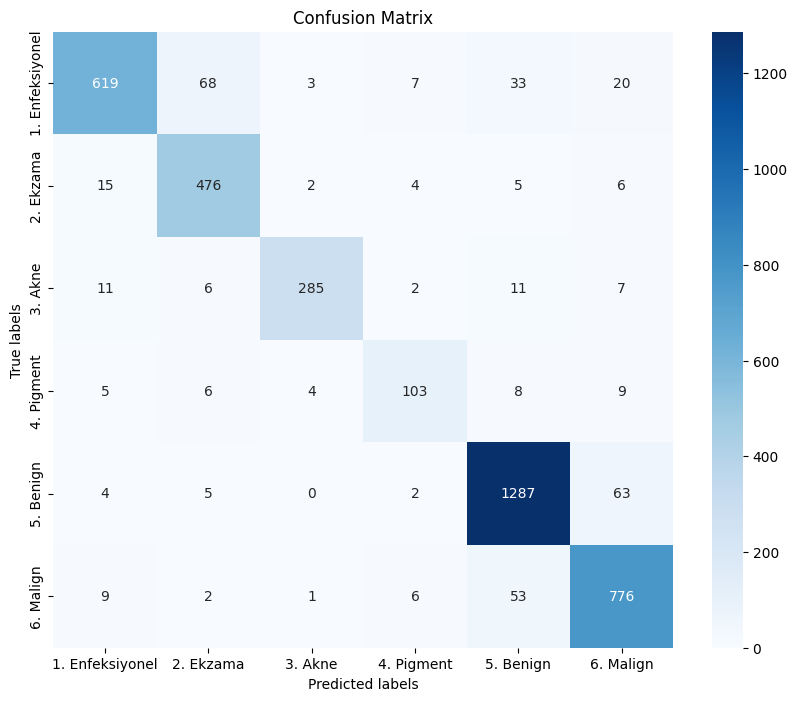

Epoch 5/10


Training: 100%|██████████| 966/966 [10:16<00:00,  1.57it/s]


Train Loss: 0.0697, Train Accuracy: 97.83%


Evaluating: 100%|██████████| 123/123 [00:26<00:00,  4.58it/s]


Validation Accuracy: 91.64%


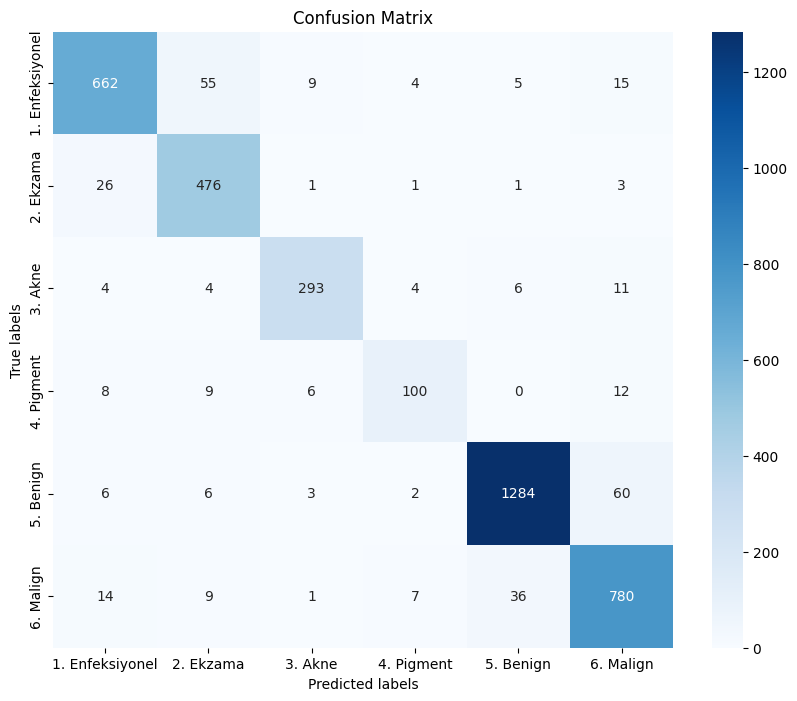

Epoch 6/10


Training: 100%|██████████| 966/966 [10:17<00:00,  1.57it/s]


Train Loss: 0.0606, Train Accuracy: 98.01%


Evaluating: 100%|██████████| 123/123 [00:26<00:00,  4.60it/s]


Validation Accuracy: 91.38%


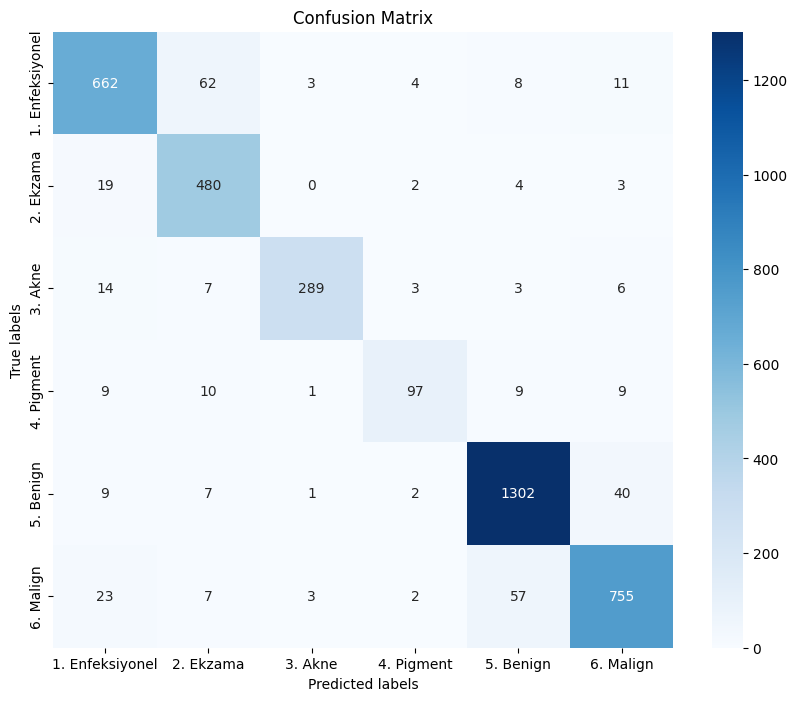

Epoch 7/10


Training: 100%|██████████| 966/966 [10:16<00:00,  1.57it/s]


Train Loss: 0.0506, Train Accuracy: 98.36%


Evaluating: 100%|██████████| 123/123 [00:27<00:00,  4.55it/s]


Validation Accuracy: 91.46%


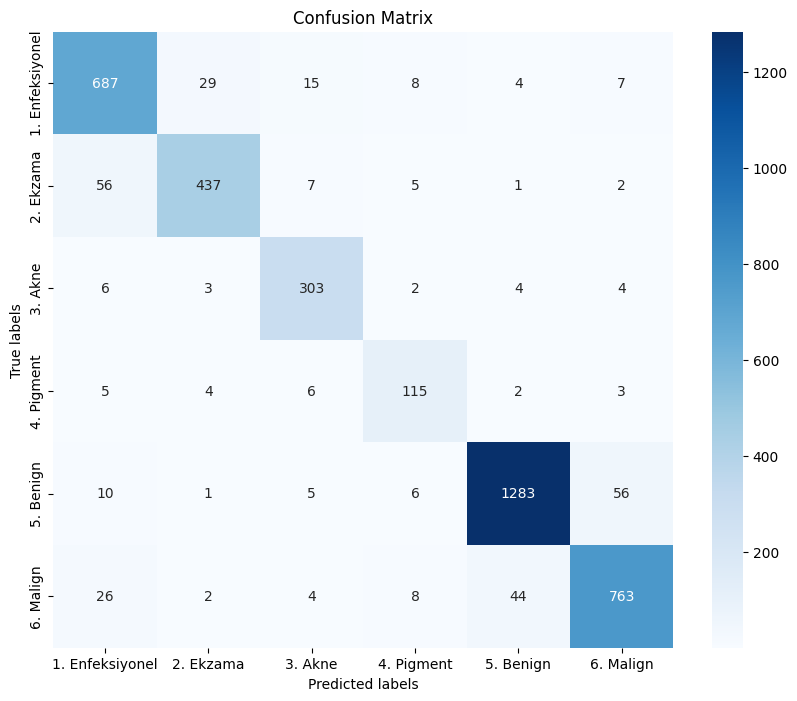

Epoch 8/10


Training: 100%|██████████| 966/966 [10:15<00:00,  1.57it/s]


Train Loss: 0.0481, Train Accuracy: 98.37%


Evaluating: 100%|██████████| 123/123 [00:26<00:00,  4.56it/s]


Validation Accuracy: 90.93%


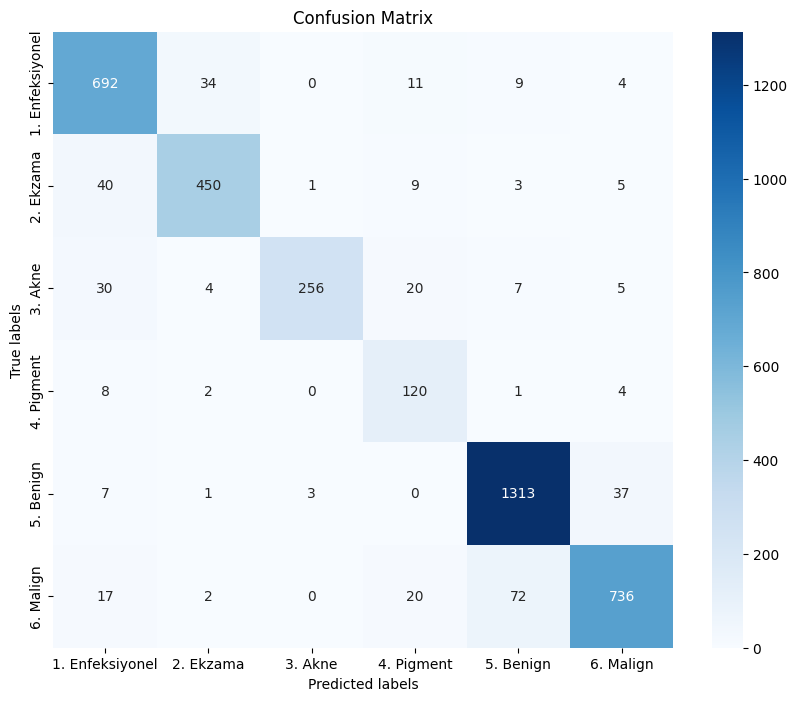

Epoch 9/10


Training: 100%|██████████| 966/966 [10:16<00:00,  1.57it/s]


Train Loss: 0.0448, Train Accuracy: 98.56%


Evaluating: 100%|██████████| 123/123 [00:26<00:00,  4.60it/s]


Validation Accuracy: 91.21%


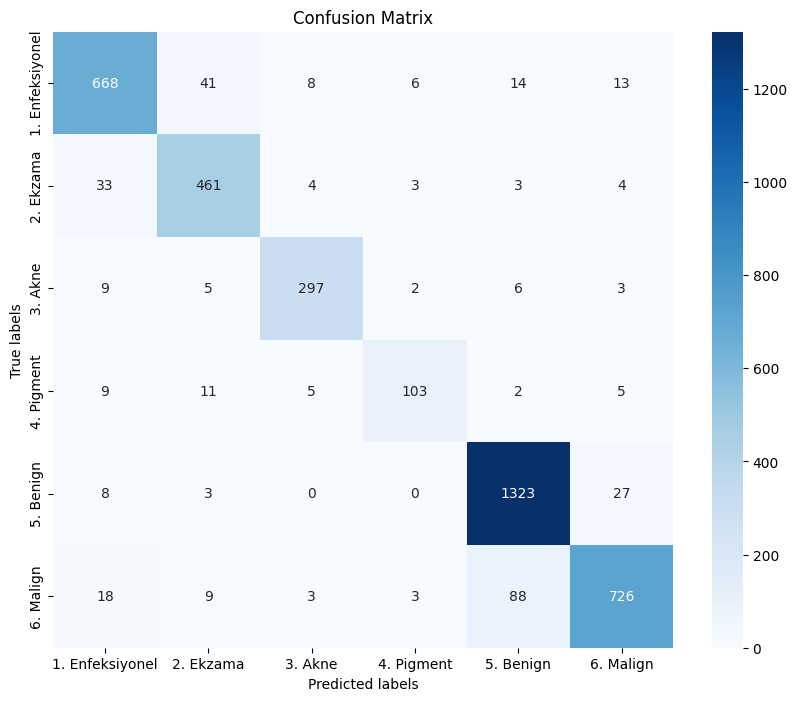

Epoch 10/10


Training: 100%|██████████| 966/966 [10:16<00:00,  1.57it/s]


Train Loss: 0.0471, Train Accuracy: 98.40%


Evaluating: 100%|██████████| 123/123 [00:26<00:00,  4.58it/s]


Validation Accuracy: 92.66%


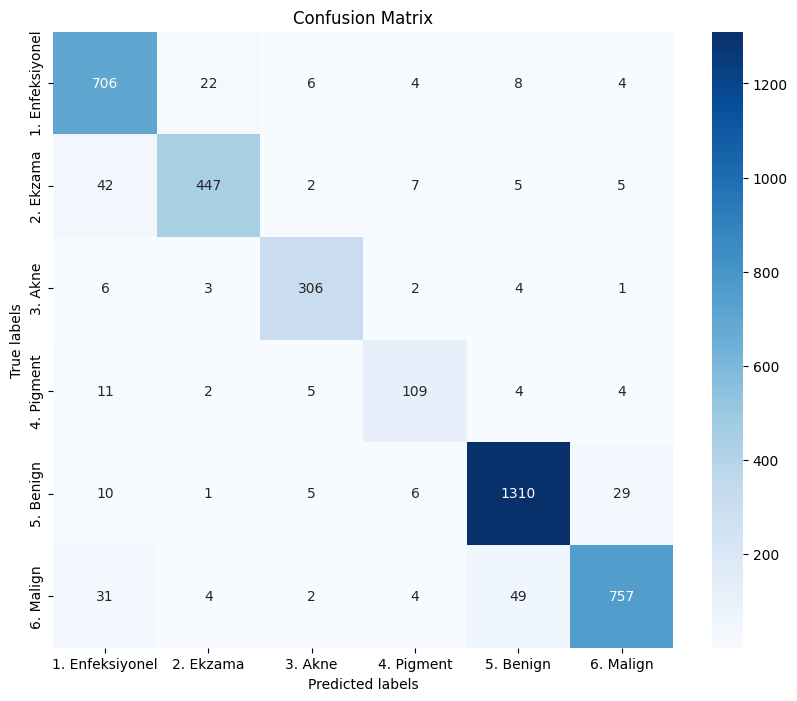

Training complete. Model saved.


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from transformers import ViTForImageClassification
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
from tqdm import tqdm
import os

# Set environment for debugging CUDA errors (helps locate errors more precisely)
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Check if GPU is available and move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define data transformations for the image dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 (required by ViT)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet stats
])

# Load your dataset (replace 'your_dataset_path' with the actual path to your data)
train_dataset = datasets.ImageFolder(root='/kaggle/input/skin-diseases/kaggle/train', transform=transform)
val_dataset = datasets.ImageFolder(root='/kaggle/input/skin-diseases/kaggle/val', transform=transform)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

# Define Vision Transformer (ViT) model for classification
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=len(train_dataset.classes))  # Use the actual number of classes

# Reset classifier layer weights after pretraining (important to fine-tune for new task)
model.classifier.weight.data.normal_(mean=0.0, std=0.02)
model.classifier.bias.data.zero_()

# Move model to GPU
model.to(device)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# Training loop function
def train(model, train_loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(train_loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        
        # Debug: Print labels to ensure they are in the correct format
        # Uncomment the next line to print labels during training
        # print(f"Labels: {labels}")
        
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images).logits
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total
    return epoch_loss, accuracy

# Evaluation loop function
def evaluate(model, val_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images).logits
            _, predicted = torch.max(outputs, 1)
            
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = 100 * correct / total
    return accuracy, all_labels, all_preds

# Plotting Confusion Matrix
def plot_confusion_matrix(all_labels, all_preds):
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

# Training and evaluating the model
num_epochs = 10

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    
    # Train for one epoch
    train_loss, train_accuracy = train(model, train_loader, optimizer, criterion)
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    
    # Evaluate on validation dataset
    val_accuracy, val_labels, val_preds = evaluate(model, val_loader)
    print(f"Validation Accuracy: {val_accuracy:.2f}%")
    
    # Plot confusion matrix for validation
    plot_confusion_matrix(val_labels, val_preds)

# Save the fine-tuned model
model.save_pretrained('path_to_save_model')

print("Training complete. Model saved.")

# To load the model later for inference:
# model = ViTForImageClassification.from_pretrained('path_to_save_model')
# model.eval()  # Set to evaluation mode for inference


In [7]:
import shutil

# Save the model to a directory
model_save_dir = 'path_to_save_model'
model.save_pretrained(model_save_dir)

# Now, create a ZIP file from the saved directory
zip_file_path = 'model.zip'
shutil.make_archive(zip_file_path.replace('.zip', ''), 'zip', model_save_dir)

print(f"Model saved and zipped as {zip_file_path}")


Model saved and zipped as model.zip


Using device: cuda


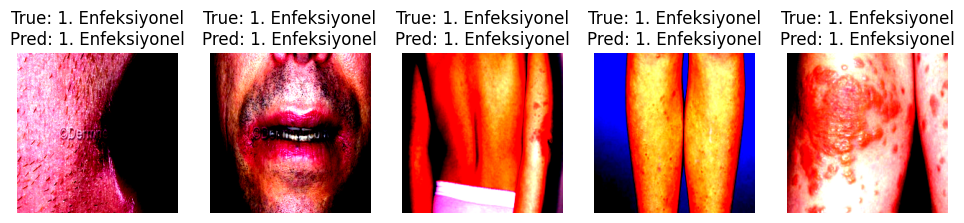


Classification Report:
                 precision    recall  f1-score   support

1. Enfeksiyonel       0.88      0.93      0.91       750
      2. Ekzama       0.91      0.87      0.89       510
        3. Akne       0.95      0.95      0.95       322
     4. Pigment       0.81      0.83      0.82       136
      5. Benign       0.95      0.96      0.95      1361
      6. Malign       0.94      0.89      0.91       849

       accuracy                           0.92      3928
      macro avg       0.91      0.91      0.91      3928
   weighted avg       0.92      0.92      0.92      3928



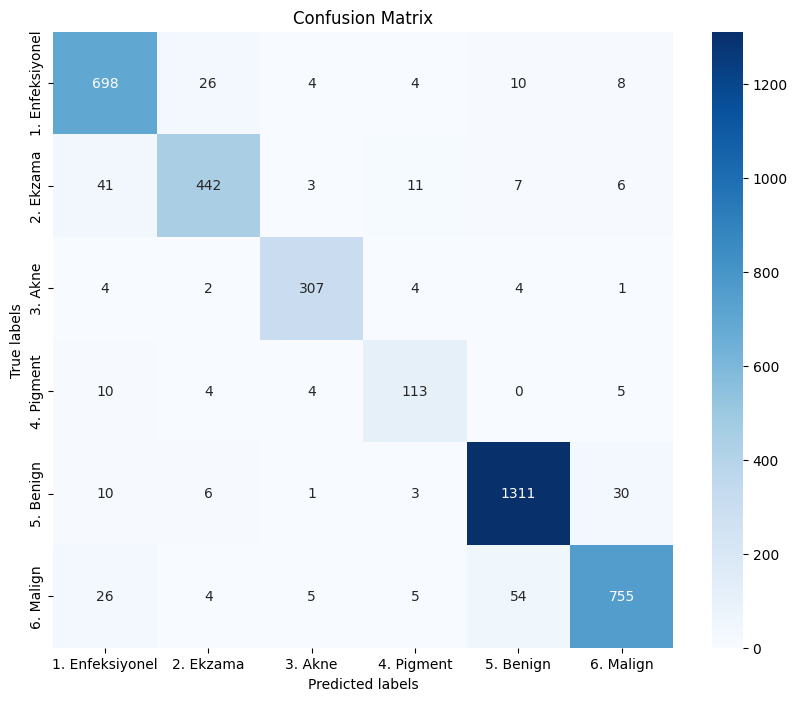

In [9]:
import torch
from transformers import ViTForImageClassification
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import os
import zipfile
import shutil
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Check if GPU is available and move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Unzip the model if it's zipped
zip_file_path = 'model.zip'
unzip_dir = 'model_dir'

# Unzipping the model directory
if not os.path.exists(unzip_dir):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(unzip_dir)

# Load the model from the unzipped directory
model = ViTForImageClassification.from_pretrained(unzip_dir)
model.to(device)
model.eval()  # Set model to evaluation mode

# Define transformations (same as during training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 (required by ViT)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet stats
])

# Load the test dataset
test_dir = '/kaggle/input/skin-diseases/kaggle/test'
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# Test data loader
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Function to make predictions
def make_predictions(model, test_loader):
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images).logits
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return all_labels, all_preds

# Get predictions
all_labels, all_preds = make_predictions(model, test_loader)

# Visualize some of the predictions
def plot_predictions(images, labels, preds, class_names, num_images=5):
    plt.figure(figsize=(12, 12))
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        ax.imshow(images[i].permute(1, 2, 0))  # Convert from Tensor to HxWxC format
        ax.set_title(f"True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}")
        ax.axis('off')
    plt.show()

# Visualizing some test images along with their true and predicted labels
test_images, _ = next(iter(test_loader))  # Get a batch of images from the test set
test_images = test_images.cpu()  # Move images to CPU for visualization
plot_predictions(test_images, all_labels[:5], all_preds[:5], test_dataset.classes)

# Print the classification report and confusion matrix (if needed)
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Classification Report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
